In [1]:
import json
import os
import re
import logging
from functools import reduce
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.model_selection import ParameterGrid

from nnattack.variables import auto_var, get_file_name
from params import (
    #nn_k1, nn_k3, nn_k5, nn_k7,
    #opt_of_rf_attack, rf_attack, rf500_attack,
    #robust_nn_k1, robust_nn_k3,
    #robust_rf,
    compare_nns,
    nn_k1_robustness,
    nn_k3_robustness,
    
    #opt_of_nnopt,
    optimality,
    
    rf_robustness,
)

auto_var.set_variable_value('random_seed', 0)
auto_var.set_variable_value('ord', 'inf')
logging.basicConfig(level=0)

Using TensorFlow backend.


In [2]:
def get_result(auto_var):
    file_name = get_file_name(auto_var, name_only=True).replace("_", "-")
    file_path = f"./results/{file_name}.json"
    if not os.path.exists(file_path):
        return None
    try:
        with open(file_path, "r") as f:
            ret = json.load(f)
    except:
        print("problem with %s" % file_path)
        raise
    return ret


def params_to_dataframe(grid_param, column=None):
    params, loaded_results = auto_var.run_grid_params(get_result, grid_param, with_hook=False, verbose=0, n_jobs=1)
    if column is None:
        results = [r['results'] if isinstance(r, dict) else r for r in loaded_results]
    else:
        results = loaded_results
    
    params, results = zip(*[(params[i], results[i]) for i in range(len(params)) if results[i]])
    params, results = list(params), list(results)
    #print(len(results))
    accs = []
    for i, param in enumerate(params):
        if column is None:
            for r in results[i]:
                #params[i][f'eps_{r["eps"]:.2f}_trn'] = r['trn_acc']
                params[i][f'eps_{r["eps"]:.2f}_tst'] = r['tst_acc']
        else:
            if column not in results[i]:
                params[i][column] = np.nan
            else:
                if column == 'avg_pert':
                    params[i][column] = results[i][column]['avg']
                    if 'missed_count' in results[i]['avg_pert']:
                        params[i]['missed_count'] = results[i]['avg_pert']['missed_count']
                    else:
                        params[i]['missed_count'] = 0
                else:
                    params[i][column] = results[i][column]
                          
    df = pd.DataFrame(params)
    return df

def set_plot(fig, ax, ord=np.inf):
    fig.autofmt_xdate()
    ax.legend()
    ax.set_ylim(0, 1)
        #ax.legend(bbox_to_anchor=(1.5, 0., 0.5, 0.5))
    ax.legend()
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    xlabel = 'Adversarial Perturbation'
    if ord == np.inf:
        ax.set_xlabel(xlabel + ' (Linf)', fontsize=15)
    else:
        ax.set_xlabel(xlabel, fontsize=15)
        
                          
def result_latex_figs(exp_name, control_var, caption):
    control = ParameterGrid(control_var)
    ret = """
\\begin{figure}[ht!]
\\centering"""
    img_paths = []
    for i, g in enumerate(control):
        dataset, ord = g['dataset'], g['ord']
        img_path = f'./figs/{exp_name}_{dataset}_{ord}.eps'
        dataset = dataset.replace("_", " ")
        ret += """
\\subfloat[%s]{
    \\includegraphics[width=.45\\textwidth]{%s}}""" % (dataset, img_path)
        if i % 2 == 1:
            ret += "\n"
    ret += """
\\caption{%s}
\\label{fig:%s}
\\end{figure} 
""" % (caption, exp_name)
    return ret
                      
def plot_result(df, exp_nme, control_var, variables, show_plot=True):
    control = ParameterGrid(control_var)
    for g in control:
        title = exp_name
        temp_df = df
                      
        for k, v in g.items():
            if v in variable_name[k]:
                title = title + f"_{variable_name[k][v]}"
            else:
                title = title + f"_{v}"
            temp_df = temp_df.loc[df[k] == v]
                      
        fig, ax = plt.subplots()
        ax.set_title(title)
        for name, group in temp_df.groupby(variables):
            #print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]
                      
            if isinstance(name, str):
                if variables[0] not in variable_name:
                    label = name
                elif name in variable_name[variables[0]]:
                    label = variable_name[variables[0]][name]
                else:
                    label = name
            else:
                mod_names = []
                for i, n in enumerate(name):
                    if n in variable_name[variables[i]]:
                        mod_names.append(variable_name[variables[i]][n])
                    else:
                        mod_names.append(n)
                label = mod_name.join("_")
            ax.plot(x, s, label=label)

        dataset = g['dataset']
        ord = g['ord']
        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.png', format='png')
        if show_plot:
            plt.show()
        else:
            plt.close()
                      
def get_avg(df, exp_nme, control_var, variables):
    control = ParameterGrid(control_var)
    for g in control:
        title = exp_name
        temp_df = df
                      
        for k, v in g.items():
            if v in variable_name[k]:
                title = title + f"_{variable_name[k][v]}"
            else:
                title = title + f"_{v}"
            temp_df = temp_df.loc[df[k] == v]
                      
        for name, group in temp_df.groupby(variables):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]
                      
variable_name = {
    #'model': {
    #    ''
    #},
    
    
    'dataset': {
        'fashion_mnist35_2200_pca5': 'f-mnist35-pca5',
        'mnist35_2200_pca5': 'mnist35-pca5',
        'fashion_mnist06_2200_pca5': 'f-mnist06-pca5',
        'fashion_mnist35_2200_pca10': 'f-mnist35-pca10',
        'mnist35_2200_pca10': 'mnist35-pca10',
        'fashion_mnist06_2200_pca10': 'f-mnist06-pca10',
        'fashion_mnist35_2200_pca15': 'f-mnist35-pca15',
        'mnist35_2200_pca15': 'mnist35-pca15',
        'fashion_mnist06_2200_pca15': 'f-mnist06-pca15',
        
        'mnist17_2200_pca25': 'mnist17-pca25',
        'fashion_mnist35_2200_pca25': 'f-mnist35-pca25',
        'mnist35_2200_pca25': 'mnist35-pca25',
        'fashion_mnist06_2200_pca25': 'f-mnist06-pca25',
        'digits_pca5': 'digits-pca5',
        'digits_pca25': 'digits-pca25',
        'halfmoon_2200': 'halfmoon',
        
        'abalone': 'abalone',
        'iris': 'iris',
        'digits_pca5': 'digits-pca5',
        'wine': 'wine',
        
        'halfmoon_300': 'halfmoon',
        'fashion_mnist35_300_pca5': 'f-mnist35-pca5',
        'mnist35_300_pca5': 'mnist35-pca5',
        'fashion_mnist06_300_pca5': 'f-mnist06-pca5',
        'fashion_mnist35_300_pca15': 'f-mnist35-pca15',
        'mnist35_2200_pca15': 'mnist35-pca15',
        'fashion_mnist06_300_pca15': 'f-mnist06-pca15',
        'fashion_mnist35_300_pca10': 'f-mnist35-pca10',
        'mnist35_2200_pca10': 'mnist35-pca10',
        'fashion_mnist06_300_pca10': 'f-mnist06-pca10',
        
        
    },
    'attack': {
        'blackbox': 'Cheng\'s',
        'kernelsub_c10000_pgd': 'kernelsub',
        'kernelsub_c1000_pgd': 'kernelsub',
        'rev_nnopt_k1_20': 'nnopt-20-ori',
        'rev_nnopt_k1_50': 'nnopt-50-ori',
        'rev_nnopt_k1_20_region': 'nnopt-20',
        'rev_nnopt_k1_50_region': 'nnopt-50',
        'rev_nnopt_k3_20': 'nnopt-20-ori',
        'rev_nnopt_k3_50': 'nnopt-50-ori',
        'rev_nnopt_k3_20_region': 'nnopt-20',
        'rev_nnopt_k3_50_region': 'nnopt-50',
        'rev_nnopt_k5_20': 'nnopt-20-ori',
        'rev_nnopt_k5_50': 'nnopt-50-ori',
        'rev_nnopt_k5_20_region': 'nnopt-20',
        'rev_nnopt_k5_50_region': 'nnopt-50',
        'rev_nnopt_k7_20': 'nnopt-20-ori',
        'rev_nnopt_k7_50': 'nnopt-50-ori',
        'rev_nnopt_k7_20_region': 'nnopt-20',
        'rev_nnopt_k7_50_region': 'nnopt-50',
        
        'nnopt_k1_all': 'nnopt-all',
        'nnopt_k3_all': 'nnopt-all',
        
        'direct_k1': 'direct attack',
        'direct_k3': 'direct attack',
        'direct_k5': 'direct attack',
        'direct_k7': 'direct attack',
        
        'rf_attack_all': 'RF-all',
        'rf_attack_rev': 'RF-rev',
        'rf_attack_rev_20': 'RF-rev-20',
        'rf_attack_rev_50': 'RF-rev-50',
        'rf_attack_rev_100': 'RF-rev-100',
    },
    'ord': {},
}


In [23]:
def knn_attack_plots(exp_name, grid_param, caption='', show_plot=True):
    df = params_to_dataframe(grid_param)
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']

    control = {
        'dataset': datasets,
        'ord': grid_param[0]['ord'],
    }
    variables = ['attack']
    plot_result(df, exp_name, control, variables, show_plot)
    return result_latex_figs(exp_name, control, caption)

def union_param_key(grid_param, key):
    if isinstance(grid_param, list):
        return set.union(*[set(g[key]) for g in grid_param])
    else:
        return grid_param[key]
    
def get_var_name(var, arg):
    if var == 'model':
        if 'adv' in arg or 'robust' in arg:
            arg = "%s_%02d" % ("_".join(arg.split("_")[:-1]), int(arg.split("_")[-1]))
        else:
            arg = arg
    else:
        arg = variable_name[var].get(arg, arg)
    return arg.replace('_', '-')

def avg_pert_table(exp_name, grid_param, columns, rows, obj='avg_pert'):
    columns = list(filter(lambda a: a not in ['n_features', 'n_samples', 'n_classes'], columns))
    if len(columns) == 0 or len(rows) == 0:
        return pd.DataFrame({})
    df = params_to_dataframe(grid_param, 'avg_pert')
    
    temp_df = df.groupby(columns + rows)[obj].mean()
    temp_df_sem = df.groupby(columns + rows)[obj].sem()
    col_grid = OrderedDict({c: union_param_key(grid_param, c) for c in columns})
    row_grid = OrderedDict({r: union_param_key(grid_param, r) for r in rows})
    d = {}
                              
    for col in ParameterGrid(col_grid):
        col_k = tuple(col[c] for c in columns)
        col_name = tuple(get_var_name(c, col[c]) for c in columns)
        d[col_name] = {}
        for row in ParameterGrid(row_grid):
            row_k = tuple(row[r] for r in rows)
            row_name = tuple(get_var_name(r, row[r]) for r in rows)
            if (col_k + row_k) in temp_df:
                #d[col_name][row_name] = "$%.3f \pm %.3f$" % (temp_df[col_k + row_k], temp_df_sem[col_k + row_k])
                d[col_name][row_name] = "$%.3f$" % (temp_df[col_k + row_k])
                d[col_name][row_name] = d[col_name][row_name].replace("0.", ".")
            else:
                d[col_name][row_name] = -1

    d = {k: d[k] for k in sorted(d.keys())}
    return pd.DataFrame(d)

def dataset_stat_column(df, grid_param, columns, rows):
    if ("n_features" not in columns) and ("n_samples" not in columns) and ("n_classes" not in columns):
        return df
    
    column_names = {
        'n_features': '\# features',
        'n_samples': '\# examples',
        'n_classes': '\# classes',
    }
    
    d = df.to_dict(into=OrderedDict)
    datasets = union_param_key(grid_param, "dataset")
    if len(d.keys()) > 0:
        first_key = list(d.keys())[0]
        row_len = 1 if isinstance(d[first_key], str) else len(first_key)
        col_len = 1 if isinstance(first_key, str) else len(first_key)
        ori_cols = list(d.keys())
    else:
        row_len = 1
        col_len = 1
        ori_cols = []
    
    for dataset in datasets:
        X, y, _ = auto_var.get_var_with_argument("dataset", dataset)
        row_name = (get_var_name("dataset", dataset), )
        for col in columns:
            if col not in column_names:
                continue
            column_name = tuple(['-' for _ in range(col_len-1)] + [column_names[col]])
            if col == "n_features":
                d.setdefault(column_name, {})[row_name] = X.shape[1]
            elif col == "n_samples":
                d.setdefault(column_name, {})[row_name] = X.shape[0]
            elif col == "n_classes":
                d.setdefault(column_name, {})[row_name] = len(np.unique(y))
    print(d)
                
    for col in ori_cols:
        d.move_to_end(col)
    print(pd.DataFrame(d))
        
    return pd.DataFrame(d)
    

def table_wrapper(exp_name, grid_params, columns, rows, obj='avg_pert', caption="", combine_method=None):
    t = """
\\begin{table}[h!]
\\tiny
\\centering
"""
    df = pd.DataFrame({})
    if combine_method is None:
        df = avg_pert_table(exp_name, grid_params, columns, rows, obj)
    else:
        dfs = [avg_pert_table(exp_name, g, columns, rows, obj) for g in grid_params]
        df = pd.concat(dfs, axis=combine_method)
    if 'dataset' in rows:
        df = dataset_stat_column(df, grid_param, columns, rows)
    t += df.to_latex(escape=False)
    t += """\\caption{%s}
\\label{table:%s_%s}
\\end{table}
""" % (caption, exp_name, obj)
    return t

tex_base = "./tex_files"

def write_to_tex(s, file_name):
    with open(os.path.join(tex_base, file_name), 'w') as f:
        f.write(s)

In [4]:
_, exp_name, grid_param, _ = nn_k1_robustness()
avg_caption = "1NN average purturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param, ['model', 'attack'], ['dataset'], caption=avg_caption)
write_to_tex(table_str, exp_name + '_table.tex')

In [5]:
_, exp_name, grid_param, _ = nn_k3_robustness()
avg_caption = "3NN average purturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param, ['model', 'attack'], ['dataset'], caption=avg_caption)
write_to_tex(table_str, exp_name + '_table.tex')

In [24]:
_, exp_name, grid_param, _ = optimality()
avg_caption = "3NN and RF average purturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param,
                          ['n_samples', 'n_features', 'n_classes', 'model', 'attack'], ['dataset'],
                          caption=avg_caption, combine_method=1)
write_to_tex(table_str, exp_name + '_table.tex')

OrderedDict([(('random-forest-3', "Cheng's"), OrderedDict([(('fashion-mnist06-300-pca25',), '$.136$'), (('fashion-mnist35-300-pca25',), '$.183$'), (('halfmoon',), '$.213$'), (('mnist17-300-pca25',), '$.177$'), (('mnist35-300-pca25',), '$.157$')])), (('random-forest-3', 'RF-all'), OrderedDict([(('fashion-mnist06-300-pca25',), '$.070$'), (('fashion-mnist35-300-pca25',), '$.096$'), (('halfmoon',), '$.132$'), (('mnist17-300-pca25',), '$.091$'), (('mnist35-300-pca25',), '$.074$')])), (('random-forest-3', 'RF-rev'), OrderedDict([(('fashion-mnist06-300-pca25',), '$.136$'), (('fashion-mnist35-300-pca25',), '$.161$'), (('halfmoon',), '$.162$'), (('mnist17-300-pca25',), '$.153$'), (('mnist35-300-pca25',), '$.123$')])), (('random-forest-3', 'RF-rev-100'), OrderedDict([(('fashion-mnist06-300-pca25',), -1), (('fashion-mnist35-300-pca25',), -1), (('halfmoon',), -1), (('mnist17-300-pca25',), -1), (('mnist35-300-pca25',), -1)])), (('knn3', 'nnopt-20'), OrderedDict([(('fashion-mnist06-300-pca25',), '$.

In [7]:
_, exp_name, grid_param, _ = rf_robustness()
avg_caption = "Random Forest average purturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param, ['model', 'attack'], ['dataset'], caption=avg_caption)
write_to_tex(table_str, exp_name + '_table.tex')

In [8]:
_, _, grid_param, _ = nn_k1_robustness()
datasets = union_param_key(grid_param, 'dataset')
exp_name = "dataset-stats"
grid_param = {
    "dataset": datasets,
}
caption = "Data set statistics"
table_str = table_wrapper(exp_name, grid_param, ['n_samples', 'n_features', 'n_classes'], ['dataset'], caption=caption)
write_to_tex(table_str, exp_name + '_table.tex')

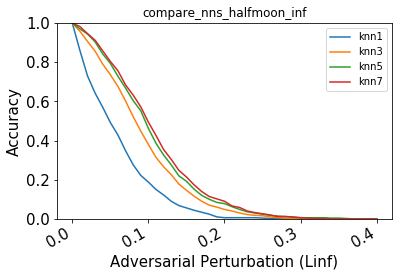

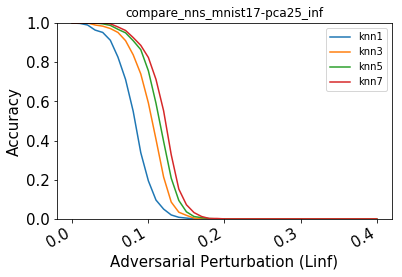

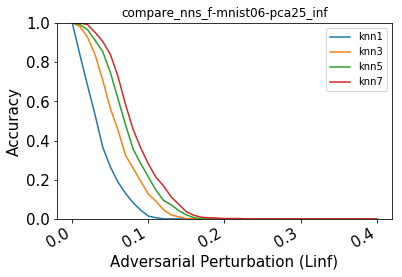

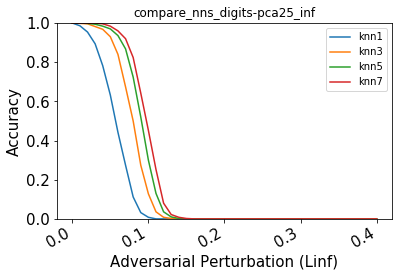

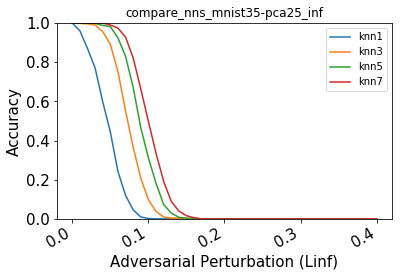

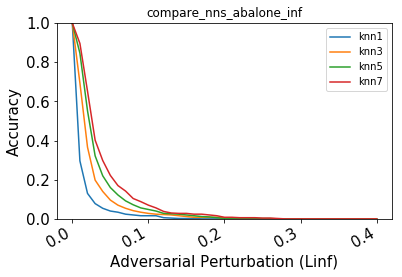

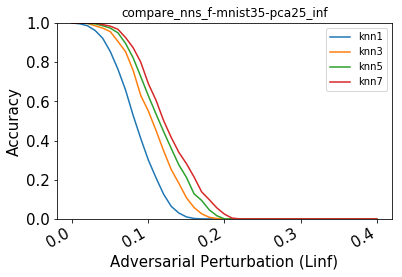

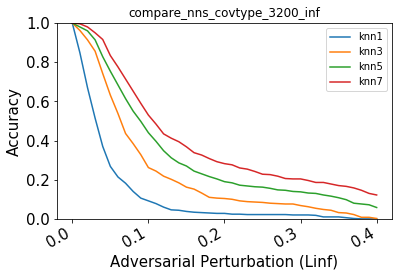

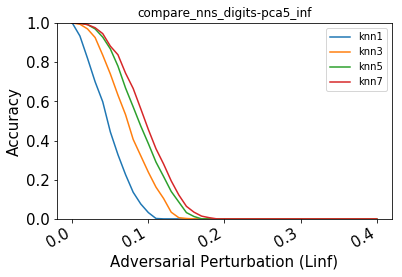

In [9]:
_, exp_name, grid_param, _ = compare_nns()

def compare_nn_plots(exp_name, grid_param, caption='', show_plot=True):
    df = params_to_dataframe(grid_param)
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']

    control = {
        'dataset': datasets,
        'ord': grid_param[0]['ord'],
    }
    variables = ['model']
    plot_result(df, exp_name, control, variables, show_plot)
    return result_latex_figs(exp_name, control, caption)
fig_str = compare_nn_plots(exp_name, grid_param, show_plot=True)
write_to_tex(fig_str, exp_name + '_fig.tex')

In [25]:
%%bash
bash ./sync_report.sh

In [11]:
experiments = [rf_attack, opt_of_rf_attack, robust_rf]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in experiments:
    _, exp_name, grid_param, _ = fn()
    print(exp_name)
    #columns = ['blackbox', 'rf_attack_rev_20', 'rf_attack_rev_100']
    table_str = table_wrapper(exp_name, grid_param, ['attack'], ['dataset'], caption=avg_caption)
    write_to_tex(table_str, exp_name + '_table.tex')
    fig_str = knn_attack_plots(exp_name, grid_param, show_plot=False)
    write_to_tex(fig_str, exp_name + '_fig.tex')

NameError: name 'rf_attack' is not defined

In [ ]:
nn_experiments = [nn_k1, nn_k3, nn_k5, nn_k7, opt_of_nnopt]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    print(grid_param)
    variables = grid_param[0]['attack']
    #variables = list(filter(lambda v: 'kernelsub' not in v and 'direct' not in v, variables))
    variables = list(filter(lambda v: 'kernelsub' not in v, variables))
    print(variables)
    table_str = table_wrapper(exp_name, grid_param, variables, caption=avg_caption)
    table_str += table_wrapper(exp_name, grid_param, variables, obj='missed_count', caption=miss_caption)
    #print(table_str)
    write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
nn_experiments = [nn_k1, nn_k3, nn_k5, nn_k7, opt_of_nnopt]
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    print(exp_name)
    fig_str = knn_attack_plots(exp_name, grid_param, show_plot=False)
    write_to_tex(fig_str, exp_name + '_fig.tex')

In [ ]:
nn_experiments = [robust_nn_k1, robust_nn_k3]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    variables = grid_param[0]['attack']
    variables = list(filter(lambda v: 'kernelsub' not in v and 'direct' not in v, variables))
    print(variables)
    table_str = table_wrapper(exp_name, grid_param, variables, caption=avg_caption)
    table_str += table_wrapper(exp_name, grid_param, variables, obj='missed_count', caption=miss_caption)
    write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
nn_experiments = [robust_nn_k1, robust_nn_k3]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    variables = grid_param[0]['attack']
    variables = list(filter(lambda v: 'kernelsub' not in v and 'direct' not in v, variables))
    print(variables)
    table_str = table_wrapper(exp_name, grid_param, variables, caption=avg_caption)
    table_str += table_wrapper(exp_name, grid_param, variables, obj='missed_count', caption=miss_caption)
    write_to_tex(table_str, exp_name + '_table.tex')